In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [14]:
N_Quantiles = 100
Quantile_Transformer = False
Box_Cox= False
Logarithm = True

## Make custom pipeline to create normal distributions for the features


In [74]:
class Feature_Transformation_Preprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
        self.n_quantiles = None
        self.quantile_transformer = None
        self.box_cox= None
        self.logarithm = None
    
    def set_transformation_type(self,n_quantiles, quantile_transformer, box_cox, logarithm):
        self.n_quantiles = n_quantiles
        self.quantile_transformer = quantile_transformer
        self.box_cox = box_cox
        self.logarithm = logarithm
        
    def _feature_transformation(self):
        super()._feature_transformation() 
        
        dataset =self.dataset
        
        if self.logarithm:
            for i in range(self.dataset.shape[1]):
                #print('before : ', self.dataset[:,i])
                self.dataset[:,i] = np.array([np.sign(x)*np.log(1+ abs(x)) for x in dataset[:,i]])             
                #print('after:', self.dataset[:,i])
        
        if self.quantile_transformer:
            for i in range(self.dataset.shape[1]):
                qt = QuantileTransformer(self.n_quantiles, output_distribution= 'normal')
                new_feature = qt.fit_transform(self.dataset[:,i].reshape(-1,1))
                self.dataset[:,i] = new_feature.flatten()
        
        if self.box_cox:
            for i in range(dataset.shape[1]):     
                bc = PowerTransformer(method='box-cox')
                new_feature = bc.fit_transform(dataset[:,i].reshape(-1,1))
                self.dataset[:,i] = new_feature.flatten()
           
            

## Load Datasets

In [75]:
p_train = Feature_Transformation_Preprocessing(load_csv('../dataset/trainset.csv'))
p_test = Feature_Transformation_Preprocessing(load_csv('../dataset/testset.csv'))


In [76]:
p_train.set_transformation_type(N_Quantiles, Quantile_Transformer, Box_Cox, Logarithm)
p_test.set_transformation_type(N_Quantiles, Quantile_Transformer, Box_Cox, Logarithm)


In [77]:
y_train , x_train= p_train.preprocess()
y_test, x_test = p_test.preprocess()

before :  [121.78731104  28.478       74.538      ...  62.328      133.204
 121.78731104]
after: [4.81045368 3.38364422 4.32463584 ... 4.14832757 4.89936103 4.81045368]
before :  [ 90.1    52.063 119.834 ...  42.916  17.066  72.435]
after: [4.5119578  3.97147989 4.7944177  ... 3.78227872 2.89403172 4.29640066]
before :  [44.395 21.773 66.795 ... 44.607 54.913 59.817]
after: [3.81540197 3.12557562 4.21648845 ... 3.82006121 4.02379691 4.10786936]
before :  [  1.774  54.51   44.244 ...  68.272 151.277   0.161]
after: [1.02029032 4.01656318 3.81207006 ... 4.23804078 5.02570123 0.1492817 ]
before :  [2.40016552 2.40016552 0.658      ... 2.40016552 0.554      2.40016552]
after: [1.22382411 1.22382411 0.50561206 ... 1.22382411 0.44083225 1.22382411]
before :  [371.54454611 371.54454611  28.226      ... 371.54454611 144.171
 371.54454611]
after: [5.92035662 5.92035662 3.37505872 ... 5.92035662 4.97791236 5.92035662]
before :  [-0.81284729 -0.81284729 -0.094      ... -0.81284729  0.087
 -0.8128

after: [ 1.17402893 -0.37225297 -0.72609828 ... -0.02219621  0.22314355
  1.12135178]
before :  [42.724      57.46327892 57.46327892 ... 57.46327892 57.46327892
 57.46327892]
after: [3.77789715 4.06839885 4.06839885 ... 4.06839885 4.06839885 4.06839885]
before :  [ 1.144      -0.01820352 -0.01820352 ... -0.01820352 -0.01820352
 -0.01820352]
after: [ 0.76267324 -0.01803982 -0.01803982 ... -0.01803982 -0.01803982
 -0.01803982]
before :  [2.183      0.01274878 0.01274878 ... 0.01274878 0.01274878 0.01274878]
after: [1.15782415 0.01266819 0.01266819 ... 0.01266819 0.01266819 0.01266819]
before :  [ 86.191  55.745 109.195 ...   0.    141.122  64.951]
after: [4.46810111 4.03856755 4.70225152 ... 0.         4.95668584 4.18891204]


In [25]:
print(x_train.shape)
print(x_test.shape)

[[ 1.          0.09260008  1.11915975 ...         nan         nan
  -1.04963898]
 [ 1.         -2.71984142  0.2753565  ...         nan         nan
   0.14948058]
 [ 1.         -1.09282203  1.6583506  ...         nan         nan
   0.3794284 ]
 ...
 [ 1.         -1.45736772  0.0290911  ...         nan         nan
   0.16461473]
 [ 1.          0.34213833 -0.86782304 ...         nan         nan
   1.37945365]
 [ 1.          0.09260008  0.7554813  ...         nan         nan
  -1.04963898]]
(25000, 31)


[[ 1.00000000e+00  1.85013498e-01  9.50020870e-01 ... -3.65927885e-03
  -7.92317380e-04 -1.19024578e+00]
 [ 1.00000000e+00 -3.86529457e+00  4.13705283e-01 ... -3.65927885e-03
  -7.92317380e-04  5.24128170e-01]
 [ 1.00000000e+00 -1.19408579e+00  1.23030549e+00 ... -6.66781959e-01
   8.78429685e-01  6.74525217e-01]
 ...
 [ 1.00000000e+00 -1.69457506e+00  2.25961191e-01 ... -3.65927885e-03
  -7.92317380e-04  5.34849892e-01]
 [ 1.00000000e+00  4.37396292e-01 -6.55445237e-01 ... -2.05217222e-01
  -2.23709453e+00  1.13299914e+00]
 [ 1.00000000e+00  1.85013498e-01  7.36123776e-01 ... -3.65927885e-03
  -7.92317380e-04 -1.19024578e+00]]


-31.682259546099825

## Prediction Function 

In [79]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on Training Set

In [80]:
w, loss = ridge_regression(y_train, x_train,0.004)
#print(w) # gives an idea about the important columns.. 
print(loss)

0.0860633628410993


##  Cross Validation

In [81]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)
        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.7404088888888889
[0.08547195 0.08567905 0.08480681 0.08555782]
[0.08531411 0.08524682 0.08553647 0.08528475]


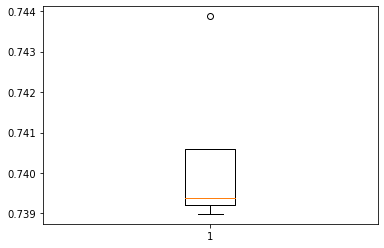

In [83]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(accs.mean())
print(test_loss)
print(train_loss)

## Tune Hyperparameters

In [84]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    lambdas = np.logspace(-7, gamma_range, 10)
    max_acc = 0
    min_loss = np.inf
    opt_lambda = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, lambda_ in enumerate(lambdas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,lambda_)
        accuracies.append([lambda_,np.median(accuracy)])
        train_losses.append([lambda_,np.median(train)])
        test_losses.append([lambda_,np.median(test)])
        if (np.median(test) < min_loss):
            min_loss = np.median(test)
            max_acc = np.median(accuracy)
            opt_lambda = lambda_
                
    return opt_lambda , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_lambda, max_acc, acc ,train, test= Tune_lambda(x_train, y_train, 5, 1)

print(f"optimal acc = {max_acc} with lambda= {opt_lambda}")

optimal acc = 0.7401333333333333 with lambda= 1e-07


## Predictions on Test Set 


In [ ]:
w_opt,loss = ridge_regression(y_train,x_train,0.00001)
p = predict(w_opt,x_test)
print((p==y_test).mean())
print(loss)